# 📦 Import Libraries

In [1]:
import os
import time

import numpy  as np
import pandas as pd

In [2]:
import folium

import matplotlib        as mpl
import matplotlib.pyplot as plt
import seaborn           as sns

from matplotlib.colors import LinearSegmentedColormap

In [3]:
from datetime import datetime, date
from datetime import timedelta

from utils.teda import TEDADetect

teda_detect = TEDADetect()

# Patterns

## Data

In [75]:
PATH_DATA = "./Datasets/Trajetos/"

PATH_PREPROCESSED_DATA_GASOLINE = "./Preprocessed_data/Gasoline/"
PATH_PREPROCESSED_DATA_ETHANOL  = "./Preprocessed_data/Ethanol"

## Graphic

In [76]:
plot_size = (18, 10)

graph_colors = {
  "black": "#1F1E1F",
  "blue":  "#03A9CE",
  "white": "#F7F7F7",
}

text_colors = {
  "title":    "#262626",
  "subtitle": "#646464",
}

PATH_FIGURES = "./Figures/"

# Auxiliar Functions

## Data Processing

In [77]:
def file_paths(fuel: str) -> list:
  fuel_path = PATH_DATA + f"[{fuel}] Trajeto Casa-Escola-UFRN/"

  return [fuel_path + file for file in os.listdir(fuel_path) if ".csv" in file]

In [78]:
def get_week_day(path: str) -> str:
  start_index = path.rfind('_') + 1
  end_index   = path.rfind('.csv')

  week_day = path[start_index:end_index].upper()

  return week_day

In [79]:
def get_data_info(fuel: str) -> pd.DataFrame:
  data_info = pd.DataFrame()

  for path in file_paths(fuel):
    data = pd.read_csv(path)

    new_row = pd.DataFrame({
      "PATH":     path,
      "WEEK_DAY": get_week_day(path),
      "ROWS": data.shape[0]
    }, index=[0])

    data_info = pd.concat([data_info, new_row], ignore_index=True)

  return data_info

In [80]:
def select_by_similarity(l1: list, l2: list) -> list:
  result = []

  for v1 in l1:
    for v2 in l2:
      if len(result) == 0 or abs(v1 - v2) < diff:
        result = [v1, v2]
        diff   = abs(v1 - v2)

  print(f"Differece: {diff}")
  
  return result

In [81]:
def fix_columns(df: pd.DataFrame) -> pd.DataFrame:
  fix_init_space = {column: column[1:] for column in list(df.columns.values) if column[0] == " "}

  return df.rename(columns=fix_init_space)

In [82]:
def create_time_columns(df: pd.DataFrame) -> pd.DataFrame:
  df_copy = df.copy()

  date_time = pd.to_datetime(df_copy["Device Time"], format="%d-%b-%Y %H:%M:%S.%f")

  df_copy.loc[:, "Time"] = date_time.round("s").dt.time
  df_copy.loc[:, "Date"] = date_time.dt.date

  df_copy.drop(columns=["Device Time"], inplace=True)

  return df_copy

In [83]:
def get_CO2(df: pd.DataFrame, fuel: str) -> pd.DataFrame:
  if fuel == "gasoline":
    fuel_density        = 737  # (g/L)
    emission_factor_CO2 = 2310 # (g/L)

  if fuel == "ethanol":
    fuel_density        = 789  # (g/L)
    emission_factor_CO2 = 1510 # (g/L)
  
  afr = df["Air Fuel Ratio(Commanded)(:1)"]
  maf = df["Mass Air Flow Rate(g/s)"]

  fuel_volume = maf / (afr * fuel_density)

  co2_emission = fuel_volume * emission_factor_CO2

  df.loc[:, "CO2"] = co2_emission

  return df

## Plotting Maps

In [84]:
def create_intervals(column: pd.Series, color_list: list) -> dict:
  n_intervals = len(color_list)
  min = column.min()
  max = column.max()
  increment = (max - min) / n_intervals

  intervals = {}

  for idx, color in enumerate(color_list):
    intervals[color] = min + (idx + 1) * increment

  return intervals

In [85]:
def column_to_colors(column: pd.Series, color_list: list = None, intervals: dict = None) -> list:
  result = []

  if not intervals and not color_list:
    return result

  if not color_list and intervals:
    color_list = list(intervals.keys())

  if not intervals and color_list:
    intervals = create_intervals(column, color_list)

  for value in column:
    for color in color_list:
      if value <= intervals[color]:
        result.append(color)

        break

  return result

In [86]:
def routeplot(df: pd.DataFrame, column: str, color_list: list = None, intervals: dict = None):
  lat = df["Latitude"]
  lon = df["Longitude"]

  points    = list(zip(lat, lon))
  route_map = folium.Map(location=[-5.8204, -35.2085], zoom_start=13)

  folium.TileLayer('cartodbpositron').add_to(route_map)
  
  polilyne  = folium.PolyLine(points, color="red").add_to(route_map)

  column_values = df[column]
  points_column = polilyne.locations

  colors = column_to_colors(df[column], color_list, intervals)

  for i, point in enumerate(points_column):
    cor = colors[i]

    if i > 0:
      folium.PolyLine(locations=[points_column[i-1], point], weight=5, color=cor).add_to(route_map)

  start_trip = [points[0][0], points[0][1]]
  final_trip = [points[-1][0], points[-1][1]]

  icon_start_trip = folium.Marker(
    location=start_trip, 
    popup=folium.Popup(' Start '),
    icon=folium.Icon(color='green', prefix='fa', icon='fa-solid fa-flag-checkered')
  )

  icon_final_trip = folium.Marker(
    location=final_trip, 
    popup=folium.Popup(' Arrival '),
    icon=folium.Icon(color='red', prefix='fa', icon='fa-solid fa-flag-checkered')
  )

  icon_start_trip.add_to(route_map)
  icon_final_trip.add_to(route_map)

  return route_map

# Data Acquisition

## Selecting Data

In order to perform a proper comparison, it is necessary to select data from a week of activity for each type of fuel, ensuring that the data is somewhat similar. This means choosing records with the same day of the week and a similar number of rows, which is directly related to the duration of the trip.

In [87]:
data_info_gasoline = get_data_info("Gasolina")
data_info_ethanol  = get_data_info("Etanol")

In [88]:
gasoline_paths = {}
ethanol_paths  = {}

And another criterion is the amount of data. To have a sufficient quantity for analysis, we have chosen a minimum of 2000 rows.

### Monday

In [89]:
monday_gasoline = data_info_gasoline.query("WEEK_DAY == 'SEG' & ROWS >= 2000").sort_values(by="ROWS", ascending=False)

monday_gasoline

,PATH,WEEK_DAY,ROWS
12,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,SEG,2285
10,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,SEG,2205


In [90]:
monday_ethanol = data_info_ethanol.query("WEEK_DAY == 'SEG' & ROWS >= 2000").sort_values(by="ROWS", ascending=False)

monday_ethanol

,PATH,WEEK_DAY,ROWS
10,./Datasets/Trajetos/[Etanol] Trajeto Casa-Esco...,SEG,2649
2,./Datasets/Trajetos/[Etanol] Trajeto Casa-Esco...,SEG,2237
3,./Datasets/Trajetos/[Etanol] Trajeto Casa-Esco...,SEG,2232


In [91]:
select_by_similarity(monday_gasoline["ROWS"].values, monday_ethanol["ROWS"].values)

Differece: 27


[2205, 2232]

By similarity, we choose indexes:
- Gasoline: 10
- Ethanol:  3

The difference is 27 rows

In [92]:
gasoline_paths["MON"] = monday_gasoline.loc[10, "PATH"]
ethanol_paths["MON"]  = monday_ethanol.loc[3, "PATH"]

### Tuesday

In [93]:
tuesday_gasoline = data_info_gasoline.query("WEEK_DAY == 'TER' & ROWS >= 2000").sort_values(by="ROWS", ascending=False)

tuesday_gasoline

,PATH,WEEK_DAY,ROWS
1,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,TER,2269
0,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,TER,2242
22,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,TER,2132
31,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,TER,2099
6,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,TER,2054
3,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,TER,2050


In [94]:
tuesday_ethanol = data_info_ethanol.query("WEEK_DAY == 'TER' & ROWS >= 2000").sort_values(by="ROWS", ascending=False)

tuesday_ethanol

,PATH,WEEK_DAY,ROWS
11,./Datasets/Trajetos/[Etanol] Trajeto Casa-Esco...,TER,2474
15,./Datasets/Trajetos/[Etanol] Trajeto Casa-Esco...,TER,2303
18,./Datasets/Trajetos/[Etanol] Trajeto Casa-Esco...,TER,2161


In [95]:
select_by_similarity(tuesday_gasoline["ROWS"].values, tuesday_ethanol["ROWS"].values)

Differece: 29


[2132, 2161]

By similarity, we choose indexes:
- Gasoline: 22
- Ethanol:  18

The difference is 29 rows

In [96]:
gasoline_paths["TUE"] = tuesday_gasoline.loc[22, "PATH"]
ethanol_paths["TUE"]  = tuesday_ethanol.loc[18, "PATH"]

### Wednesday

In [97]:
wednesday_gasoline = data_info_gasoline.query("WEEK_DAY == 'QUA' & ROWS >= 2000").sort_values(by="ROWS", ascending=False)

wednesday_gasoline

,PATH,WEEK_DAY,ROWS
18,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,QUA,2227
38,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,QUA,2109
32,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,QUA,2072
27,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,QUA,2057


In [98]:
wednesday_ethanol = data_info_ethanol.query("WEEK_DAY == 'QUA' & ROWS >= 2000").sort_values(by="ROWS", ascending=False)

wednesday_ethanol

,PATH,WEEK_DAY,ROWS
13,./Datasets/Trajetos/[Etanol] Trajeto Casa-Esco...,QUA,2144
9,./Datasets/Trajetos/[Etanol] Trajeto Casa-Esco...,QUA,2064


In [99]:
select_by_similarity(wednesday_gasoline["ROWS"].values, wednesday_ethanol["ROWS"].values)

Differece: 7


[2057, 2064]

By similarity, we choose indexes:
- Gasoline: 27
- Ethanol:  9

The difference is 7 rows

In [100]:
gasoline_paths["WED"] = wednesday_gasoline.loc[27, "PATH"]
ethanol_paths["WED"]  = wednesday_ethanol.loc[9, "PATH"]

### Thursday

In [101]:
thursday_gasoline = data_info_gasoline.query("WEEK_DAY == 'QUI' & ROWS >= 2000").sort_values(by="ROWS", ascending=False)

thursday_gasoline

,PATH,WEEK_DAY,ROWS
17,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,QUI,2489
23,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,QUI,2205
2,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,QUI,2180
13,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,QUI,2179
34,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,QUI,2177
15,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,QUI,2172
11,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,QUI,2027
29,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,QUI,2021


In [102]:
thursday_ethanol = data_info_ethanol.query("WEEK_DAY == 'QUI' & ROWS >= 2000").sort_values(by="ROWS", ascending=False)

thursday_ethanol

,PATH,WEEK_DAY,ROWS
0,./Datasets/Trajetos/[Etanol] Trajeto Casa-Esco...,QUI,2354
1,./Datasets/Trajetos/[Etanol] Trajeto Casa-Esco...,QUI,2312
5,./Datasets/Trajetos/[Etanol] Trajeto Casa-Esco...,QUI,2274
4,./Datasets/Trajetos/[Etanol] Trajeto Casa-Esco...,QUI,2143


In [103]:
select_by_similarity(thursday_gasoline["ROWS"].values, thursday_ethanol["ROWS"].values)

Differece: 29


[2172, 2143]

By similarity, we choose indexes:
- Gasoline: 15
- Ethanol:  4

The difference is 29 rows

In [104]:
gasoline_paths["THU"] = thursday_gasoline.loc[15, "PATH"]
ethanol_paths["THU"]  = thursday_ethanol.loc[4, "PATH"]

### Friday

In [105]:
friday_gasoline = data_info_gasoline.query("WEEK_DAY == 'SEX' & ROWS >= 2000").sort_values(by="ROWS", ascending=False)

friday_gasoline

,PATH,WEEK_DAY,ROWS
35,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,SEX,2218
5,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,SEX,2184
37,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,SEX,2072
4,./Datasets/Trajetos/[Gasolina] Trajeto Casa-Es...,SEX,2015


In [106]:
friday_ethanol = data_info_ethanol.query("WEEK_DAY == 'SEX' & ROWS >= 2000").sort_values(by="ROWS", ascending=False)

friday_ethanol

,PATH,WEEK_DAY,ROWS
6,./Datasets/Trajetos/[Etanol] Trajeto Casa-Esco...,SEX,2233
7,./Datasets/Trajetos/[Etanol] Trajeto Casa-Esco...,SEX,2221
16,./Datasets/Trajetos/[Etanol] Trajeto Casa-Esco...,SEX,2110


In [107]:
select_by_similarity(friday_gasoline["ROWS"].values, friday_ethanol["ROWS"].values)

Differece: 3


[2218, 2221]

By similarity, we choose indexes:
- Gasoline: 35
- Ethanol:  7

The difference is 3 rows

In [108]:
gasoline_paths["FRI"] = friday_gasoline.loc[35, "PATH"]
ethanol_paths["FRI"]  = friday_ethanol.loc[7, "PATH"]

### Selected Data

| Fuel     | Week Day  | Date        |
|:--------:|:---------:|:-----------:|
| Gasoline | Monday    | 2022-Oct-31 |
| Ethanol  | Monday    | 2023-Feb-27 |
| Gasoline | Tuesday   | 2022-Nov-22 |
| Ethanol  | Tuesday   | 2023-Mar-14 |
| Gasoline | Wednesday | 2022-Nov-16 |
| Ethanol  | Wednesday | 2023-Feb-15 |
| Gasoline | Thursday  | 2022-Nov-03 |
| Ethanol  | Thursday  | 2023-Feb-16 |
| Gasoline | Friday    | 2022-Oct-31 |
| Ethanol  | Friday    | 2023-Feb-24 |

#### Gasoline

In [109]:
gasoline_paths

{'MON': './Datasets/Trajetos/[Gasolina] Trajeto Casa-Escola-UFRN/trackLog-2022-Oct-31_06-36-58_seg.csv',
 'TUE': './Datasets/Trajetos/[Gasolina] Trajeto Casa-Escola-UFRN/trackLog-2022-Nov-22_06-34-32_ter.csv',
 'WED': './Datasets/Trajetos/[Gasolina] Trajeto Casa-Escola-UFRN/trackLog-2022-Nov-16_06-39-10_qua.csv',
 'THU': './Datasets/Trajetos/[Gasolina] Trajeto Casa-Escola-UFRN/trackLog-2022-Nov-03_06-35-20_qui.csv',
 'FRI': './Datasets/Trajetos/[Gasolina] Trajeto Casa-Escola-UFRN/trackLog-2022-Oct-14_06-41-57_sex.csv'}

In [110]:
monday_gasoline    = pd.read_csv(gasoline_paths["MON"])
tuesday_gasoline   = pd.read_csv(gasoline_paths["TUE"])
wednesday_gasoline = pd.read_csv(gasoline_paths["WED"])
thursday_gasoline  = pd.read_csv(gasoline_paths["THU"])
friday_gasoline    = pd.read_csv(gasoline_paths["FRI"])

#### Ethanol

In [111]:
ethanol_paths

{'MON': './Datasets/Trajetos/[Etanol] Trajeto Casa-Escola-UFRN/trackLog-2023-Feb-27_06-41-02_seg.csv',
 'TUE': './Datasets/Trajetos/[Etanol] Trajeto Casa-Escola-UFRN/trackLog-2023-Mar-14_06-39-58_ter.csv',
 'WED': './Datasets/Trajetos/[Etanol] Trajeto Casa-Escola-UFRN/trackLog-2023-Feb-15_06-39-28_qua.csv',
 'THU': './Datasets/Trajetos/[Etanol] Trajeto Casa-Escola-UFRN/trackLog-2023-Feb-16_06-32-36_qui.csv',
 'FRI': './Datasets/Trajetos/[Etanol] Trajeto Casa-Escola-UFRN/trackLog-2023-Feb-24_06-41-36_sex.csv'}

In [112]:
monday_ethanol    = pd.read_csv(ethanol_paths["MON"])
tuesday_ethanol   = pd.read_csv(ethanol_paths["TUE"])
wednesday_ethanol = pd.read_csv(ethanol_paths["WED"])
thursday_ethanol  = pd.read_csv(ethanol_paths["THU"])
friday_ethanol    = pd.read_csv(ethanol_paths["FRI"])

# Preprocessing Data

In [113]:
selected_columns = [
  "Device Time",
  "Latitude",
  "Longitude",
  "Speed (OBD)(km/h)",
  "Engine RPM(rpm)",
  "Intake Air Temperature(°C)",
  "Air Fuel Ratio(Commanded)(:1)",
  "Mass Air Flow Rate(g/s)"
]

## Gasoline

To compare on the same amount of data, we reduce the data to 2000

In [114]:
monday_gasoline    = monday_gasoline.iloc[:2000, :]
tuesday_gasoline   = tuesday_gasoline.iloc[:2000, :]
wednesday_gasoline = wednesday_gasoline.iloc[:2000, :]
thursday_gasoline  = thursday_gasoline.iloc[:2000, :]
friday_gasoline    = friday_gasoline.iloc[:2000, :]

Removing spaces in the name of each column

In [115]:
monday_gasoline    = fix_columns(monday_gasoline)
tuesday_gasoline   = fix_columns(tuesday_gasoline)
wednesday_gasoline = fix_columns(wednesday_gasoline)
thursday_gasoline  = fix_columns(thursday_gasoline)
friday_gasoline    = fix_columns(friday_gasoline)

Selecting columns of interest

In [116]:
monday_gasoline    = monday_gasoline[selected_columns]
tuesday_gasoline   = tuesday_gasoline[selected_columns]
wednesday_gasoline = wednesday_gasoline[selected_columns]
thursday_gasoline  = thursday_gasoline[selected_columns]
friday_gasoline    = friday_gasoline[selected_columns]

Compute CO₂

In [117]:
monday_gasoline    = get_CO2(monday_gasoline,    "gasoline")
tuesday_gasoline   = get_CO2(tuesday_gasoline,   "gasoline")
wednesday_gasoline = get_CO2(wednesday_gasoline, "gasoline")
thursday_gasoline  = get_CO2(thursday_gasoline,  "gasoline")
friday_gasoline    = get_CO2(friday_gasoline,    "gasoline")

## Ethanol

To compare on the same amount of data, we reduce the data to 2000

In [118]:
monday_ethanol    = monday_ethanol.iloc[:2000, :]
tuesday_ethanol   = tuesday_ethanol.iloc[:2000, :]
wednesday_ethanol = wednesday_ethanol.iloc[:2000, :]
thursday_ethanol  = thursday_ethanol.iloc[:2000, :]
friday_ethanol    = friday_ethanol.iloc[:2000, :]

Removing spaces in the name of each column

In [119]:
monday_ethanol    = fix_columns(monday_ethanol)
tuesday_ethanol   = fix_columns(tuesday_ethanol)
wednesday_ethanol = fix_columns(wednesday_ethanol)
thursday_ethanol  = fix_columns(thursday_ethanol)
friday_ethanol    = fix_columns(friday_ethanol)

Selecting columns of interest

In [120]:
monday_ethanol    = monday_ethanol[selected_columns]
tuesday_ethanol   = tuesday_ethanol[selected_columns]
wednesday_ethanol = wednesday_ethanol[selected_columns]
thursday_ethanol  = thursday_ethanol[selected_columns]
friday_ethanol    = friday_ethanol[selected_columns]

Compute CO₂

In [121]:
monday_ethanol    = get_CO2(monday_ethanol,    "ethanol")
tuesday_ethanol   = get_CO2(tuesday_ethanol,   "ethanol")
wednesday_ethanol = get_CO2(wednesday_ethanol, "ethanol")
thursday_ethanol  = get_CO2(thursday_ethanol,  "ethanol")
friday_ethanol    = get_CO2(friday_ethanol,    "ethanol")

# Data Analysis

## TEDA Behavior

To see an example of the results using different values for the parameter **m**

In [122]:
monday_gasoline_TEDA = monday_gasoline[["Speed (OBD)(km/h)", "CO2"]]
monday_ethanol_TEDA  = monday_ethanol[["Speed (OBD)(km/h)", "CO2"]]

teda_results = pd.DataFrame()

for m in np.linspace(1, 4, 7):
  teda_detect.run_offline(monday_gasoline_TEDA, "CO2", m)
  teda_detect.run_offline(monday_ethanol_TEDA,  "CO2", m)

  gasoline_outliers_detected = (monday_gasoline_TEDA["is_outlier"] == 1).sum()
  ethanol_outliers_detected  = (monday_ethanol_TEDA["is_outlier"] == 1).sum()

  monday_gasoline_TEDA.drop(columns=["is_outlier"], inplace=True)
  monday_ethanol_TEDA.drop(columns=["is_outlier"], inplace=True)

  teda_results.loc["Gasoline", f"{m}"] = gasoline_outliers_detected
  teda_results.loc["Ethanol", f"{m}"]  = ethanol_outliers_detected

/home/matheus/Desktop/Pessoal/Conect2AI/WFIoT/teda.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_outlier'] = 0
/home/matheus/Desktop/Pessoal/Conect2AI/WFIoT/teda.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_outlier'] = 0
/tmp/ipykernel_46925/2321932869.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Features:  CO2
Dimensions:  1.0
Outlier value counts
is_outlier
0    1567
1     433
Name: count, dtype: int64
Features:  CO2
Dimensions:  1.0
Outlier value counts
is_outlier
0    1933
1      67
Name: count, dtype: int64
Features:  CO2
Dimensions:  1.5
Outlier value counts
is_outlier
0    1661
1     339
Name: count, dtype: int64
Features:  CO2
Dimensions:  1.5
Outlier value counts
is_outlier
0    1981
1      19
Name: count, dtype: int64
Features:  CO2
Dimensions:  2.0
Outlier value counts
is_outlier
0    1789
1     211
Name: count, dtype: int64
Features:  CO2
Dimensions:  2.0
Outlier value counts
is_outlier
0    1997
1       3
Name: count, dtype: int64
Features:  CO2
Dimensions:  2.5
Outlier value counts
is_outlier
0    1877
1     123
Name: count, dtype: int64
Features:  CO2
Dimensions:  2.5
Outlier value counts
is_outlier
0    2000
Name: count, dtype: int64
Features:  CO2
Dimensions:  3.0
Outlier value counts
is_outlier
0    1914
1      86
Name: count, dtype: int64
Features:  CO2
Dimen

/tmp/ipykernel_46925/2321932869.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monday_gasoline_TEDA.drop(columns=["is_outlier"], inplace=True)
/tmp/ipykernel_46925/2321932869.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monday_ethanol_TEDA.drop(columns=["is_outlier"], inplace=True)


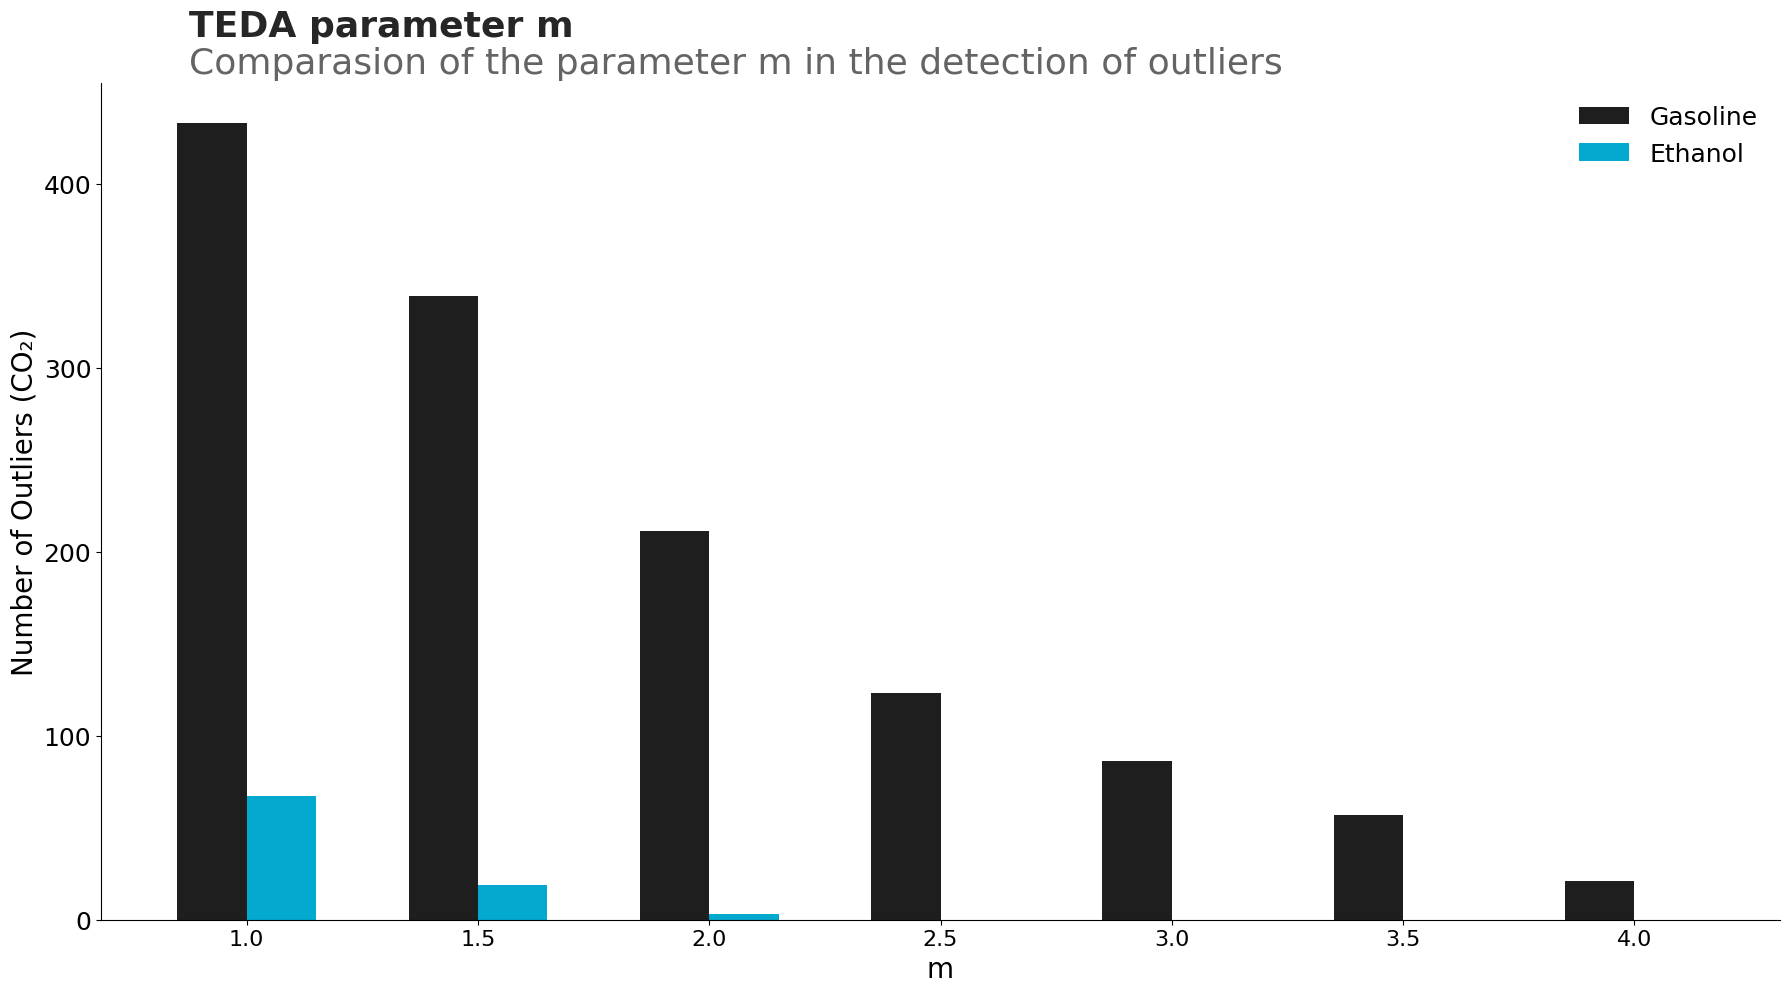

In [139]:
m_intervals = teda_results.columns.values
gasoline_m  = teda_results.loc["Gasoline", :].values
ethanol_m   = teda_results.loc["Ethanol", :].values

bar_width = 0.3

group_position = np.arange(len(m_intervals))

fig, ax = plt.subplots(figsize=plot_size)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.bar(group_position - bar_width/2, gasoline_m, bar_width, color=graph_colors["black"], label="Gasoline")
ax.bar(group_position + bar_width/2, ethanol_m, bar_width, color=graph_colors["blue"], label="Ethanol")

plt.text(-0.25, 480, "TEDA parameter m", fontsize=26, color=text_colors["title"], weight="bold")
plt.text(-0.25, 460, "Comparasion of the parameter m in the detection of outliers", fontsize=26, color=text_colors["subtitle"])

ax.set_ylabel("Number of Outliers (CO₂)", fontsize=20)
ax.set_xlabel("m", fontsize=20)
ax.set_xticks(group_position)
ax.set_xticklabels(m_intervals, fontsize=16)

ax.legend(frameon=False, fontsize=18)

plt.tight_layout()
plt.savefig(f"{PATH_FIGURES}TEDA_parameter_m.png", dpi=300, transparent=True)

plt.show()

## TEDA with m=1.5

In [124]:
teda_detect.run_offline(monday_gasoline,    "CO2")
teda_detect.run_offline(tuesday_gasoline,   "CO2")
teda_detect.run_offline(wednesday_gasoline, "CO2")
teda_detect.run_offline(thursday_gasoline,  "CO2")
teda_detect.run_offline(friday_gasoline,    "CO2")

teda_detect.run_offline(monday_ethanol,    "CO2")
teda_detect.run_offline(tuesday_ethanol,   "CO2")
teda_detect.run_offline(wednesday_ethanol, "CO2")
teda_detect.run_offline(thursday_ethanol,  "CO2")
teda_detect.run_offline(friday_ethanol,    "CO2")

Features:  CO2
Dimensions:  1.5
Outlier value counts
is_outlier
0    1645
1     355
Name: count, dtype: int64
Features:  CO2
Dimensions:  1.5
Outlier value counts
is_outlier
0    1615
1     385
Name: count, dtype: int64
Features:  CO2
Dimensions:  1.5
Outlier value counts
is_outlier
0    1583
1     417
Name: count, dtype: int64
Features:  CO2
Dimensions:  1.5
Outlier value counts
is_outlier
0    1635
1     365
Name: count, dtype: int64
Features:  CO2
Dimensions:  1.5
Outlier value counts
is_outlier
0    1682
1     318
Name: count, dtype: int64
Features:  CO2
Dimensions:  1.5
Outlier value counts
is_outlier
0    1986
1      14
Name: count, dtype: int64
Features:  CO2
Dimensions:  1.5
Outlier value counts
is_outlier
0    1945
1      55
Name: count, dtype: int64
Features:  CO2
Dimensions:  1.5
Outlier value counts
is_outlier
0    1935
1      65
Name: count, dtype: int64
Features:  CO2
Dimensions:  1.5
Outlier value counts
is_outlier
0    1991
1       9
Name: count, dtype: int64
Features: 

In [125]:

co2_gasoline_outliers_by_week_day = np.array([
  monday_gasoline.query("is_outlier == 1")["is_outlier"].sum(),
  tuesday_gasoline.query("is_outlier == 1")["is_outlier"].sum(),
  wednesday_gasoline.query("is_outlier == 1")["is_outlier"].sum(),
  thursday_gasoline.query("is_outlier == 1")["is_outlier"].sum(),
  friday_gasoline.query("is_outlier == 1")["is_outlier"].sum()
])

co2_ethanol_outliers_by_week_day = np.array([
  monday_ethanol.query("is_outlier == 1")["is_outlier"].sum(),
  tuesday_ethanol.query("is_outlier == 1")["is_outlier"].sum(),
  wednesday_ethanol.query("is_outlier == 1")["is_outlier"].sum(),
  thursday_ethanol.query("is_outlier == 1")["is_outlier"].sum(),
  friday_ethanol.query("is_outlier == 1")["is_outlier"].sum()
])

hm = np.array([
  co2_gasoline_outliers_by_week_day,
  co2_ethanol_outliers_by_week_day
])

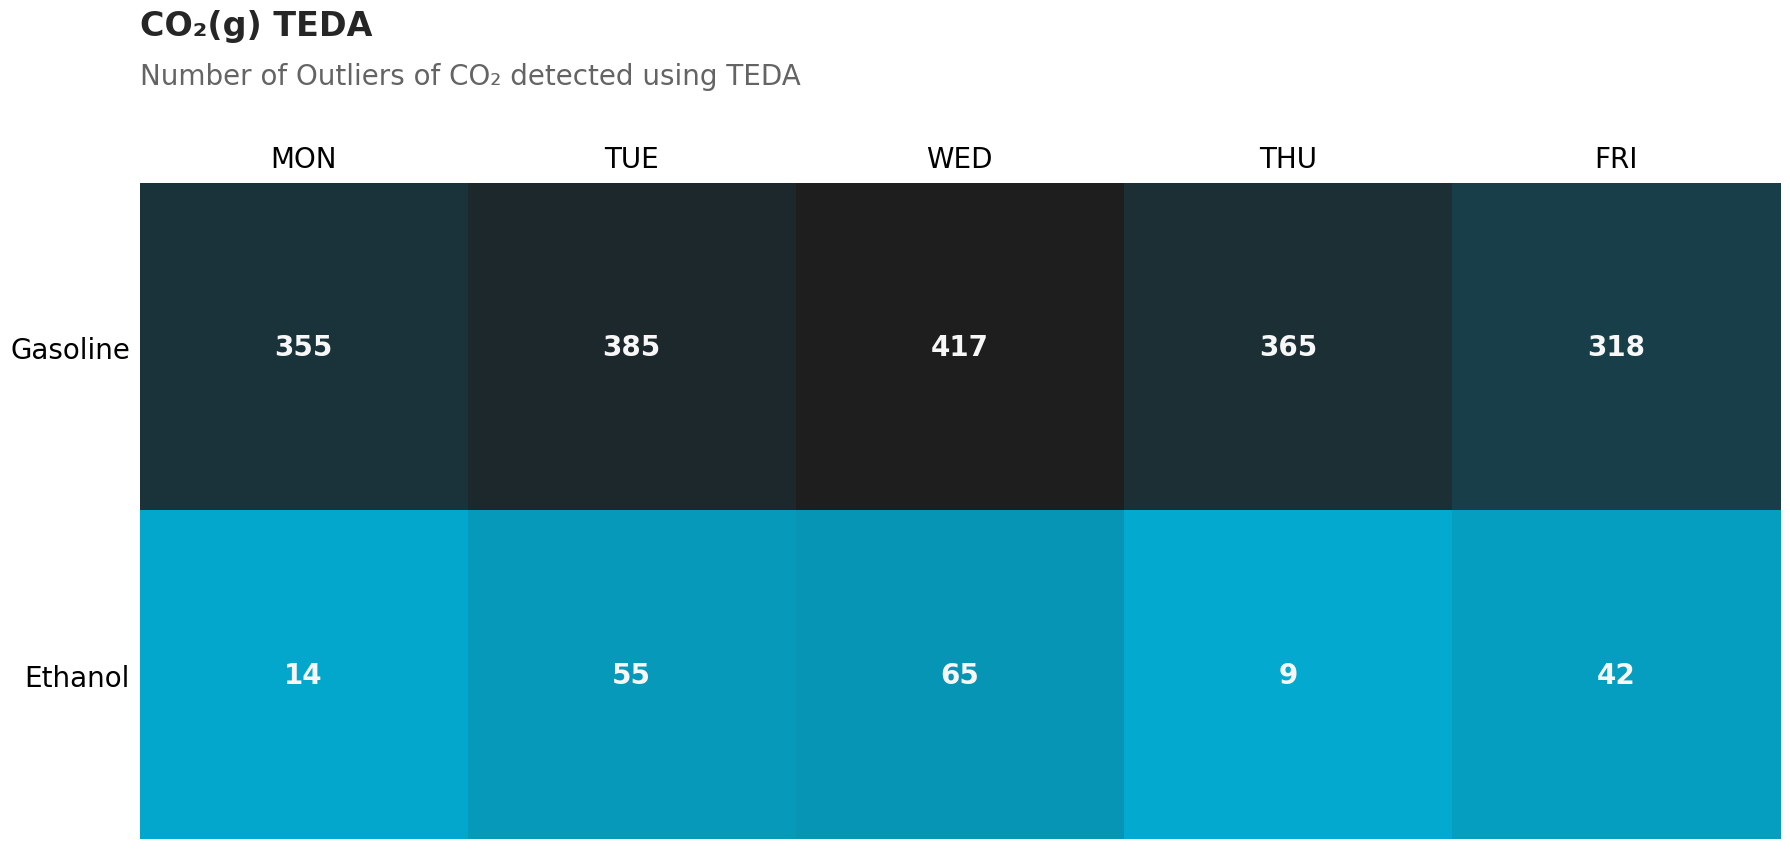

In [126]:
fig, ax = plt.subplots(figsize=plot_size)

ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

cmap = LinearSegmentedColormap.from_list("custom_colormap", [graph_colors["blue"], graph_colors["black"]])

heatmap = plt.imshow(hm, cmap=cmap)

ax.set_xticks(np.arange(hm.shape[1]))
ax.set_yticks(np.arange(hm.shape[0]))
ax.set_xticklabels(["MON", "TUE", "WED", "THU", "FRI"], fontsize=20)
ax.set_yticklabels(["Gasoline", "Ethanol"], fontsize=20)

ax.xaxis.set_ticks_position('top')

ax.tick_params(left=False, top=False)

for i in range(hm.shape[0]):
  for j in range(hm.shape[1]):
    ax.text(j, i, f"{hm[i, j]}", ha="center", va="center", color=graph_colors["white"], fontsize=20, weight="bold")


plt.text(-0.5, -0.95, "CO₂(g) TEDA", fontsize=24, color=text_colors["title"], weight="bold")
plt.text(-0.5, -0.80, "Number of Outliers of CO₂ detected using TEDA", fontsize=20, color=text_colors["subtitle"])

plt.tight_layout()
plt.savefig(f"{PATH_FIGURES}teda_co2.png", dpi=300, transparent=True)

plt.show()

## Emissions by Week Day

In [127]:
co2_gasoline_mean_by_week_day = [
  monday_gasoline["CO2"].mean(),
  tuesday_gasoline["CO2"].mean(),
  wednesday_gasoline["CO2"].mean(),
  thursday_gasoline["CO2"].mean(),
  friday_gasoline["CO2"].mean()
]

co2_ethanol_mean_by_week_day = [
  monday_ethanol["CO2"].mean(),
  tuesday_ethanol["CO2"].mean(),
  wednesday_ethanol["CO2"].mean(),
  thursday_ethanol["CO2"].mean(),
  friday_ethanol["CO2"].mean()
]

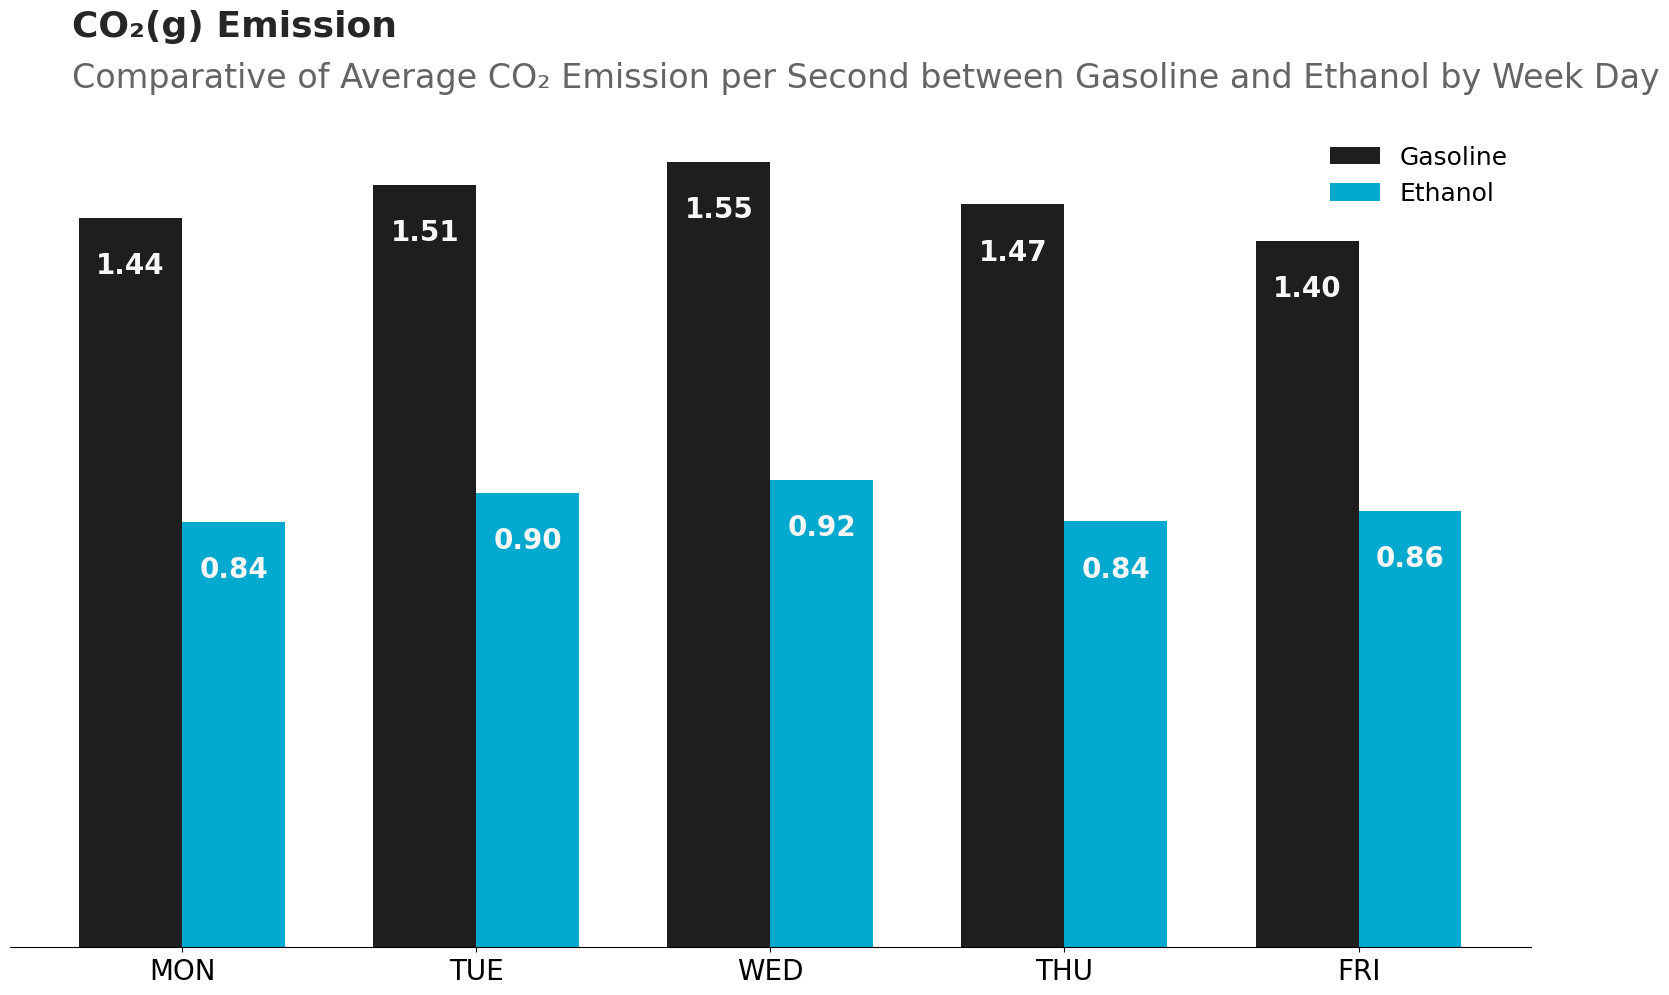

In [128]:
week_days = ["MON", "TUE", "WED", "THU", "FRI"]

bar_width = 0.35
gasoline_pos = np.arange(len(week_days))
ethanol_pos  = gasoline_pos + bar_width

fig, ax = plt.subplots(figsize=plot_size)

ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.tick_params(left = False)

group1_bar = ax.bar(gasoline_pos, co2_gasoline_mean_by_week_day, bar_width, label="Gasoline", color=graph_colors["black"])
group2_bar = ax.bar(ethanol_pos,  co2_ethanol_mean_by_week_day,  bar_width, label="Ethanol",  color=graph_colors["blue"])

ax.set_xticks(gasoline_pos + bar_width / 2)
ax.set_yticklabels([])
ax.set_xticklabels(week_days, fontsize=20)


def autolabel(barras):
    for barra in barras:
        height = barra.get_height()

        ax.annotate(
            f"{height:.2f}", weight="bold", color=graph_colors["white"], fontsize=20,
            xy=(barra.get_x() + barra.get_width() / 2, height - 0.13),
            xytext=(0, 3), textcoords="offset points", ha="center", va="bottom"
        )

autolabel(group1_bar)
autolabel(group2_bar)

plt.text(-0.2, 1.8, "CO₂(g) Emission", fontsize=26, color=text_colors["title"], weight="bold")
plt.text(-0.2, 1.7, "Comparative of Average CO₂ Emission per Second between Gasoline and Ethanol by Week Day", fontsize=24, color=text_colors["subtitle"])

ax.legend(frameon=False, fontsize=18)
plt.tight_layout()
plt.savefig(f"{PATH_FIGURES}avg_emissions.png", dpi=300, transparent=True)
plt.show()

## Emissions Cumulative Sum

In [129]:
co2_cumsum_gasoline_mean = np.mean([
  monday_gasoline["CO2"].cumsum(),
  tuesday_gasoline["CO2"].cumsum(),
  wednesday_gasoline["CO2"].cumsum(),
  thursday_gasoline["CO2"].cumsum(),
  friday_gasoline["CO2"].cumsum()
], axis=0)

co2_cumsum_ethanol_mean = np.mean([
  monday_ethanol["CO2"].cumsum(),
  tuesday_ethanol["CO2"].cumsum(),
  wednesday_ethanol["CO2"].cumsum(),
  thursday_ethanol["CO2"].cumsum(),
  friday_ethanol["CO2"].cumsum()
], axis=0)

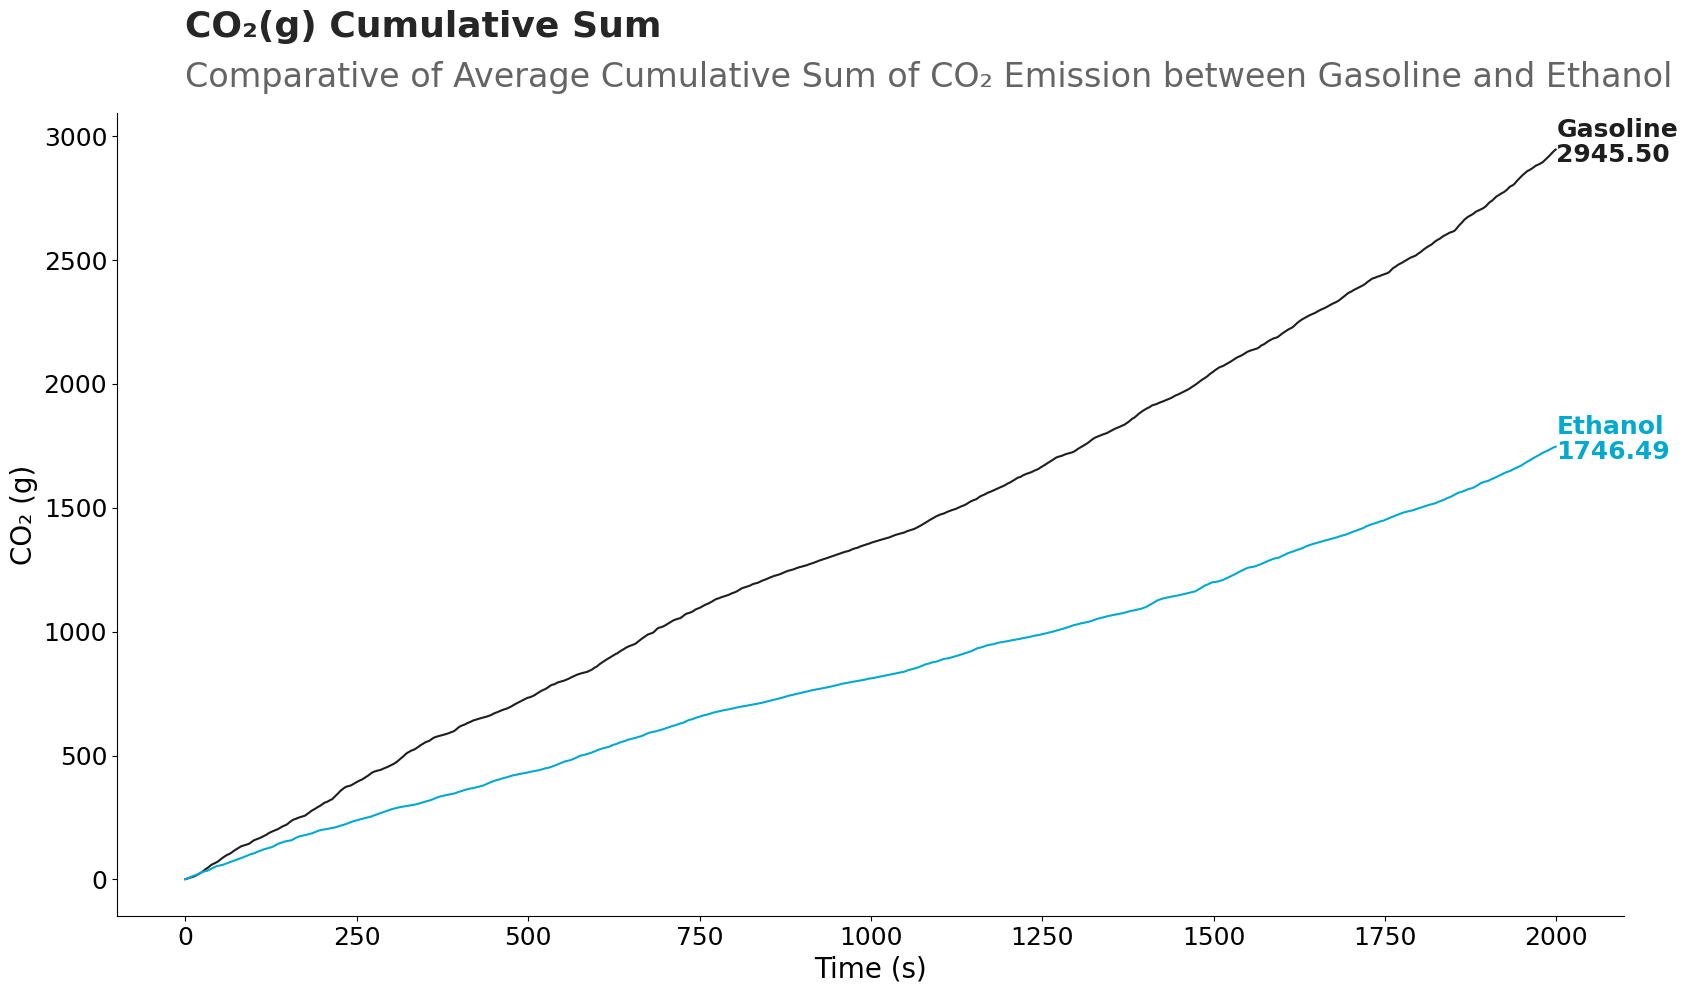

In [138]:
fig, ax = plt.subplots(figsize=plot_size)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_ylabel("CO₂ (g)", fontsize=20)
ax.set_xlabel("Time (s)", fontsize=20)

plt.xticks(rotation=0, ha="center", fontsize=18)
plt.yticks(fontsize=18)

ax.plot(co2_cumsum_gasoline_mean, color=graph_colors["black"])
ax.plot(co2_cumsum_ethanol_mean, color=graph_colors["blue"])

plt.text(2000, co2_cumsum_gasoline_mean[-1]+50, "Gasoline", weight="bold", color=graph_colors["black"], fontsize=18)
plt.text(2000, co2_cumsum_ethanol_mean[-1]+50,  "Ethanol",   weight="bold", color=graph_colors["blue"],  fontsize=18)

plt.text(2000, co2_cumsum_gasoline_mean[-1]-50, f"{co2_cumsum_gasoline_mean[-1]:.2f}", weight="bold", color=graph_colors["black"], fontsize=18)
plt.text(2000, co2_cumsum_ethanol_mean[-1]-50,  f"{co2_cumsum_ethanol_mean[-1]:.2f}",  weight="bold", color=graph_colors["blue"],  fontsize=18)

plt.text(0, 3400, "CO₂(g) Cumulative Sum", fontsize=26, color=text_colors["title"], weight="bold")
plt.text(0, 3200, "Comparative of Average Cumulative Sum of CO₂ Emission between Gasoline and Ethanol", fontsize=24, color=text_colors["subtitle"])

plt.tight_layout()
plt.savefig(f"{PATH_FIGURES}avg_cumsum.png", dpi=300, transparent=True)

plt.show()

## TEDA with m=1.5 in CO₂

## Outliers and Mean

In [131]:
monday_gasoline["week_day"]    = "MON"
tuesday_gasoline["week_day"]   = "TUE"
wednesday_gasoline["week_day"] = "WED"
thursday_gasoline["week_day"]  = "THU"
friday_gasoline["week_day"]    = "FRI"

monday_ethanol["week_day"]    = "MON"
tuesday_ethanol["week_day"]   = "TUE"
wednesday_ethanol["week_day"] = "WED"
thursday_ethanol["week_day"]  = "THU"
friday_ethanol["week_day"]    = "FRI"

gasoline_week = pd.concat([
  monday_gasoline,
  tuesday_gasoline,
  wednesday_gasoline,
  thursday_gasoline,
  friday_gasoline
], ignore_index=True)

ethanol_week = pd.concat([
  monday_ethanol,
  tuesday_ethanol,
  wednesday_ethanol,
  thursday_ethanol,
  friday_ethanol
], ignore_index=True)

week_dict = {
  1: "MON",
  2: "TUE",
  3: "WED",
  4: "THU",
  5: "FRI"
}

palette = sns.color_palette(["#1F1E1F", "#0C1D21", "#0F3A43", "#08677C", "#03A9CE"])

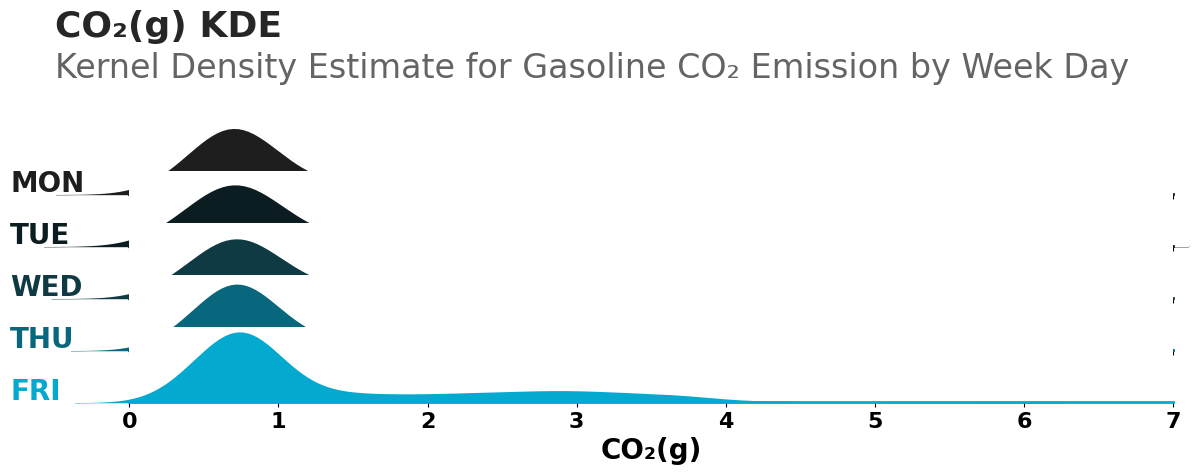

In [132]:
g = sns.FacetGrid(gasoline_week, row="week_day", hue="week_day", aspect=15, height=0.75, palette=palette)

g.map(sns.kdeplot, "CO2", bw_adjust=1, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "CO2", bw_adjust=1, clip_on=False, color="w", lw=2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

for i, ax in enumerate(g.axes.flat):
    ax.text(-0.8, 0.02, week_dict[i+1], fontweight="bold", fontsize=20, color=ax.lines[-1].get_color())
    

g.fig.subplots_adjust(hspace=-0.3)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.setp(ax.get_xticklabels(), fontsize=16, fontweight="bold")
plt.xlabel("CO₂(g)", fontweight="bold", fontsize=20)
plt.xlim(0, 7)

ax.text(-0.5, 4.5, "CO₂(g) KDE", fontsize=26, color=text_colors["title"], weight="bold")
ax.text(-0.5, 4.0, "Kernel Density Estimate for Gasoline CO₂ Emission by Week Day", fontsize=24, color=text_colors["subtitle"])

plt.savefig(f"{PATH_FIGURES}co2_kde_gasoline.png", dpi=300, transparent=True)

plt.show()

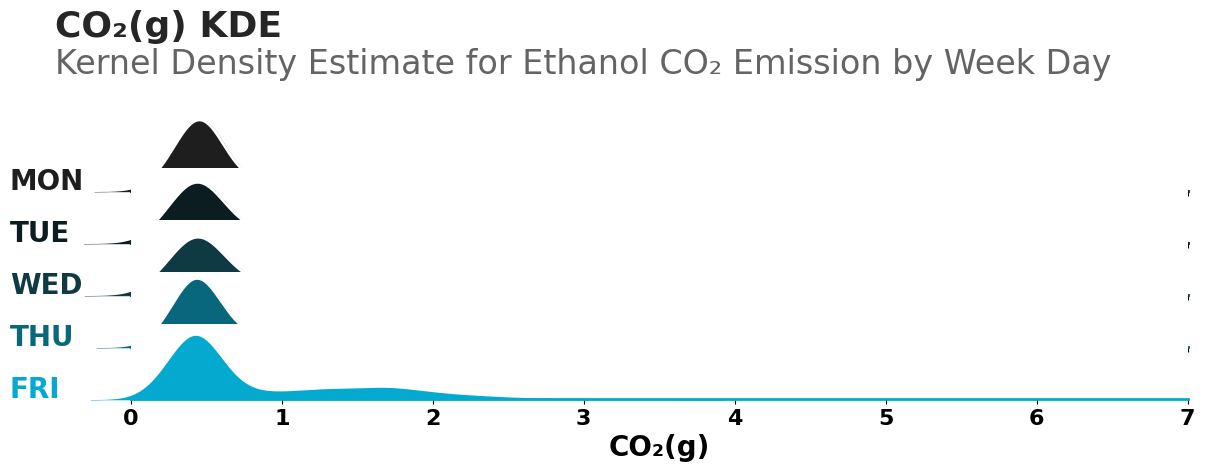

In [133]:
g = sns.FacetGrid(ethanol_week, row="week_day", hue="week_day", aspect=15, height=0.75, palette=palette)

g.map(sns.kdeplot, "CO2", bw_adjust=1, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "CO2", bw_adjust=1, clip_on=False, color="w", lw=2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

for i, ax in enumerate(g.axes.flat):
    ax.text(-0.8, 0.02, week_dict[i+1], fontweight="bold", fontsize=20, color=ax.lines[-1].get_color())
    

g.fig.subplots_adjust(hspace=-0.3)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.setp(ax.get_xticklabels(), fontsize=16, fontweight="bold")
plt.xlabel("CO₂(g)", fontweight="bold", fontsize=20)
plt.xlim(0, 7)

ax.text(-0.5, 7.8, "CO₂(g) KDE", fontsize=26, color=text_colors["title"], weight="bold")
ax.text(-0.5, 7.0, "Kernel Density Estimate for Ethanol CO₂ Emission by Week Day", fontsize=24, color=text_colors["subtitle"])

plt.savefig(f"{PATH_FIGURES}co2_kde_ethanol.png", dpi=300, transparent=True)

plt.show()

## Map Plot

In [134]:
co2_colors = {
  '#fdff7d': 1.0,
  '#fcff33': 2.0,
  '#ffd333': 3.0,
  '#fab00f': 4.0,
  '#fa6d0f': 5.0,
  '#ff523b': 6.0
}

In [135]:
route_map_gasoline = routeplot(monday_gasoline, "CO2", color_list=co2_colors)

route_map_gasoline

In [136]:
route_map_ethanol = routeplot(monday_ethanol, "CO2", color_list=co2_colors)

# save_folium_fig(route_map_ethanol, "route_map_ethanol")

route_map_ethanol